# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of Structure-Based Virtual Screening (SBVS), molecular descriptors and machine learning techniques for identifying active and inactive compounds from [Postera.ai](https://postera.ai/)'s [COVID Moonshot](https://covid.postera.ai/covid). The values from the fluorescence test at 50 μM are used for labeling the compounds into either active or inactive.

Welch's t-test is applied for selecting the molecular descriptors most likely to be related to the compound activity. These descriptors are also filtered with Recursive Feature Elimination in order to find the most relevant ones (those that will feed the ML classifiers).     

The construction of the models, as well as the training, testing and validation steps, are presented in this separate [notebook](https://github.com/caiocrocha/COVID-19/blob/master/SARS-CoV-2/postera.ai/notebooks/ML_pipeline.ipynb). The best hyperparameters for each classifier can be found in this [notebook](https://github.com/caiocrocha/COVID-19/blob/master/SARS-CoV-2/postera.ai/notebooks/ML_grid_search.ipynb), and the additional data in the [supplementary](https://github.com/caiocrocha/COVID-19/blob/master/SARS-CoV-2/postera.ai/notebooks/supplementary) folder. 

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

1. [Reading the data](#reading)    
    1. [Activity data](#activity)     
    2. [Molecular descriptors](#descriptors)    
    3. [Docking results](#docking)    
2. [Dataset distribution](#distribution)    
3. [Feature selection](#feature)    
    1. [T-test](#t-test)    
    2. [RFE](#rfe)    
    3. [Selected descriptors](#selected)    
4. [Constructing the models](#constructing)
    1. [Influence of the docking scores on the model performance](#docking_test)    
6. [Supplementary data](#supplementary)    
    1. [Influence of the docking scores on the model performance (training scores)](#docking_training)    

<a id='reading'></a>
## Reading the data
<a id='activity'></a>
### Activity data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def write_data(name):
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open(name, 'wb') as f:
        f.write(r.content)

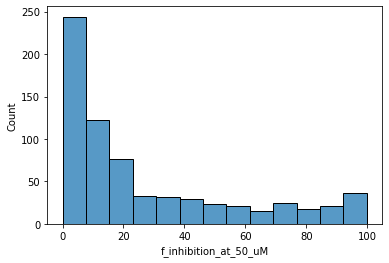

In [3]:
# Fetch activity data
write_data('activity_data.csv')

# Read activity data
activity = pd.read_csv('activity_data.csv')

# Remove activators (inhibition < 0)
activity.dropna(subset=['f_inhibition_at_50_uM'], inplace=True)
activity = activity.query('f_inhibition_at_50_uM > 0 and f_inhibition_at_50_uM < 100')

# Label actives and inactives in relation to the fluorescence assay
activity['activity'] = activity['f_inhibition_at_50_uM'] > 50
activity['activity'] = activity['activity'].astype(int) # 1 for active, 0 for inactive

sns.histplot(x=activity['f_inhibition_at_50_uM'])
plt.savefig('figures/f_inhibition_at_50uM.png', dpi=128)

In [4]:
def rdkit_2d_coordinates(activity):
    from rdkit import Chem
    # Write into smiles
    activity[['SMILES','CID']].to_csv('smiles.smi', sep=' ', index=False, header=None)
    suppl = Chem.SmilesMolSupplier('smiles.smi')
    # Compute 2D coordinates
    coordinates = [x for x in suppl if x is not None]
    return coordinates

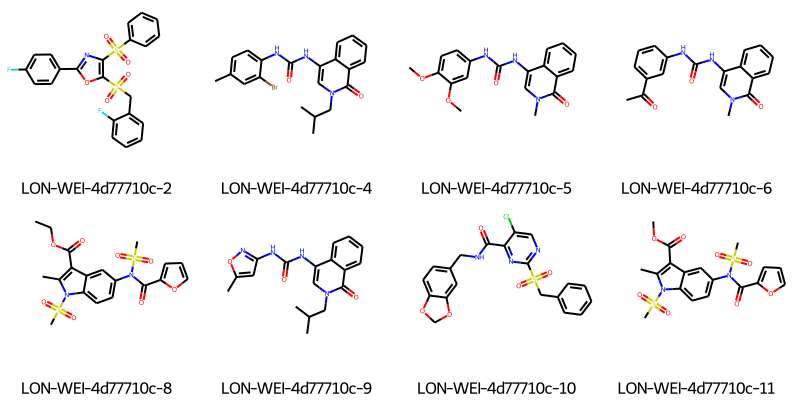

In [5]:
coordinates = rdkit_2d_coordinates(activity)

# Draw some of the molecules
from rdkit.Chem import Draw
Draw.MolsToGridImage(coordinates[:8],
        molsPerRow=4,
        subImgSize=(200,200),
        legends=[x.GetProp("_Name") for x in coordinates[:8]])

<a id='descriptors'></a>
### Molecular descriptors

In [6]:
def write_mordred_descriptors(smiles, csv, overwrite=False):
    import os
    if os.path.isfile(smiles):
        if overwrite or not os.path.isfile(csv + '.gz'):
            os.system(f'python -m mordred {smiles} > {csv}')

    if os.path.isfile(csv):
        os.system(f'gzip {csv}')

In [7]:
# Calculate descriptors if they haven't been calculated yet
write_mordred_descriptors('smiles.smi', 'mordred.csv', overwrite=False)

In [8]:
# Read descriptors
descriptors = pd.read_csv('mordred.csv.gz', compression='gzip')
descriptors.rename(columns={'name': 'CID'}, inplace=True)
descriptors.dropna(axis=1, inplace=True)
descriptors_list = descriptors.columns.tolist()[1:]

In [9]:
data = pd.merge(activity[['CID','activity']], descriptors)
data.to_csv('data.csv.gz', index=False, compression='gzip')
data.head()

,CID,activity,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,LON-WEI-4d77710c-1,0,20.632065,16.443181,0,0,35.035859,2.445284,4.890568,35.035859,...,10.200216,62.102922,367.153206,7.649025,1994,44,138.0,162.0,9.250000,6.138889
1,LON-WEI-4d77710c-2,1,25.297042,20.315486,0,0,40.837678,2.543248,4.995426,40.837678,...,10.530522,82.481808,475.035971,10.107148,2761,54,174.0,207.0,11.013889,6.791667
2,LON-WEI-4d77710c-4,0,20.960235,16.710275,0,0,33.876492,2.459754,4.919507,33.876492,...,10.216801,62.171922,427.089539,8.716113,1902,43,140.0,163.0,9.861111,5.888889
3,LON-WEI-4d77710c-5,0,19.924959,15.898187,0,0,33.473756,2.446612,4.893224,33.473756,...,10.194178,61.002084,353.137556,7.847501,1774,43,134.0,158.0,9.000000,5.888889
4,LON-WEI-4d77710c-6,0,19.436632,15.446253,0,0,31.768398,2.446255,4.892511,31.768398,...,10.142701,59.810985,335.126991,7.979214,1580,40,130.0,152.0,8.750000,5.472222


In [11]:
# Split training and validation sets
training = data.sample(frac=0.8, random_state=28)
training.to_csv('training_set.csv.gz', index=False, compression='gzip')

samples = training['CID'].tolist()
validation = data.query('CID not in @samples')
validation.to_csv('validation_set.csv.gz', index=False, compression='gzip')

<a id='docking'></a>
### Docking results

In [15]:
# Read QuickVina02 results
qvina         = pd.read_csv('../docking/qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('../docking/rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv('../docking/plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('../docking/rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores
docking = pd.merge(top_qvina, top_plants)
docking.to_csv('docking.csv', index=False)

<a id='distribution'></a>
## Dataset distribution

,activity,percentage
0,inactive,79.053085
1,active,20.946915


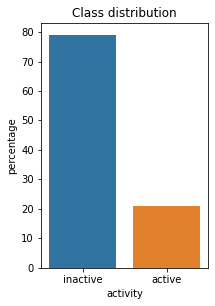

In [16]:
label = {0: 'inactive', 1: 'active'}
names = data['activity'].copy()
names.update([label[i] for i in data['activity']])

distribution = names.value_counts(
    normalize=True).mul(100).reset_index().rename({'activity':'percentage','index':'activity'}, axis=1)

plt.figure(figsize=(3, 4.5))
sns.barplot(data=distribution, x='activity', y='percentage')
plt.title('Class distribution')
plt.savefig('figures/class-ditribution.png', dpi=128)
distribution

<a id='feature'></a>
## Feature selection
<a id='t_test'></a>
### T-test
https://www.scribbr.com/statistics/t-test/

In [17]:
from scipy.stats import ttest_ind

inactives = training.query('activity == 0')
actives = training.query('activity == 1')

ttest = []
for col in descriptors_list:
    tvalue, pvalue = ttest_ind(inactives[col], actives[col], equal_var=False)
    if pvalue < 0.05:
        ttest.append([col, tvalue, pvalue])

ttest = pd.DataFrame(ttest, columns=['feature','t_value','p_value'])
ttest.sort_values('t_value', ascending=False, inplace=True)

# Select the top 20 descriptors
features = ttest['feature'].tolist()[:20]
ttest.head()

,feature,t_value,p_value
317,VSA_EState7,6.852363,7.586111e-11
201,GATS3m,6.183941,4.874121e-09
197,GATS3Z,6.088637,7.904755e-09
200,GATS1m,5.952781,1.127165e-08
196,GATS1Z,5.820511,2.283436e-08


In [18]:
ttest

,feature,t_value,p_value
317,VSA_EState7,6.852363,7.586111e-11
201,GATS3m,6.183941,4.874121e-09
197,GATS3Z,6.088637,7.904755e-09
200,GATS1m,5.952781,1.127165e-08
196,GATS1Z,5.820511,2.283436e-08
...,...,...,...
322,AMID_X,-5.090283,1.136339e-06
314,EState_VSA9,-5.121205,1.032079e-06
273,SsCl,-5.180478,8.324691e-07
262,NsCl,-5.260249,5.866276e-07


Text(0.5, 1.015, 'Histogram plots of the tested features')

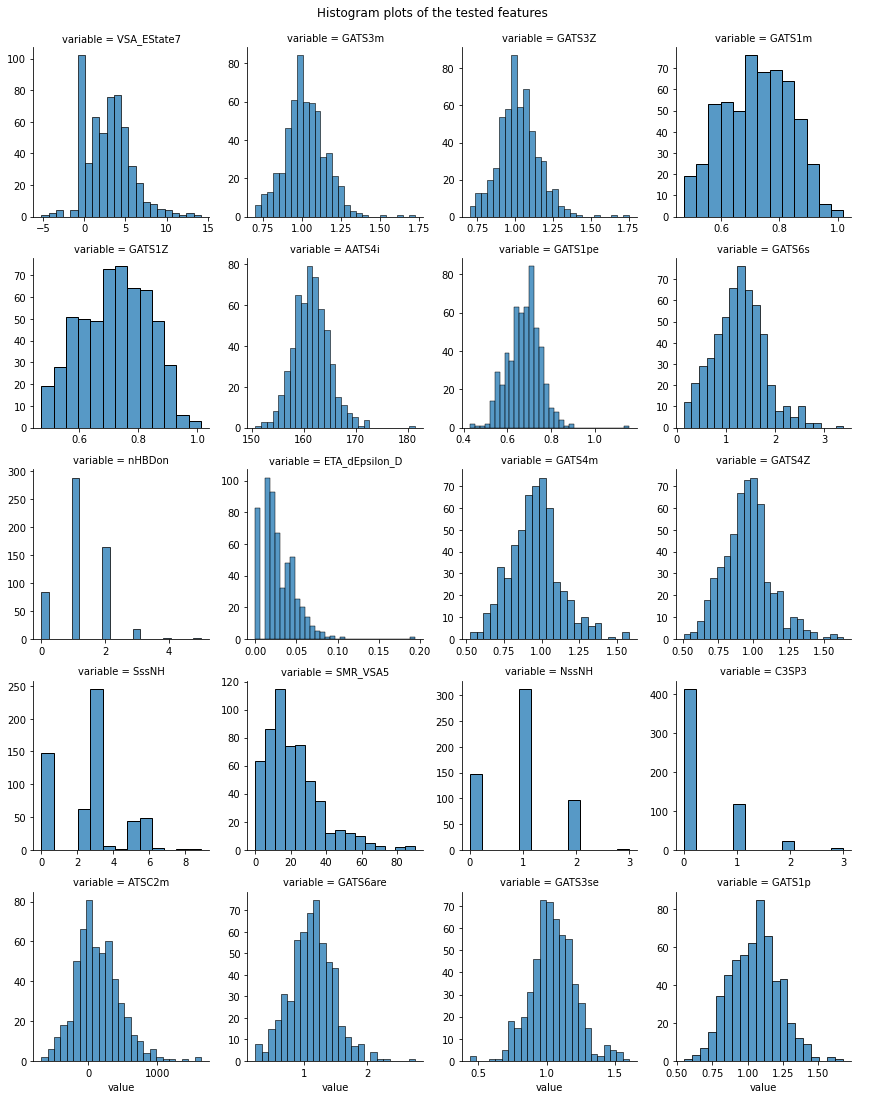

In [17]:
melt = pd.melt(training, id_vars=['CID','activity'], value_vars=features)
g = sns.FacetGrid(data=melt, col='variable', sharex=False, sharey=False, col_wrap=4)
g.map(sns.histplot, 'value').add_legend()
plt.suptitle('Histogram plots of the tested features', y=1.015)

In [19]:
# The T-test assumes normality, so let's select the features that are approximately normally distributed
selected = ['GATS3m', 'GATS3Z', 'GATS1m', 'GATS1Z', 'AATS4i', 'GATS1pe', 'GATS6s', 'nHBDon', 'GATS4m', 'GATS4Z', 'GATS3se', 'NssNH', 'ATSC2m', 'GATS6are', 'GATS6se', 'GATS1p']

In [20]:
y = training['activity']
X = training[selected].copy()

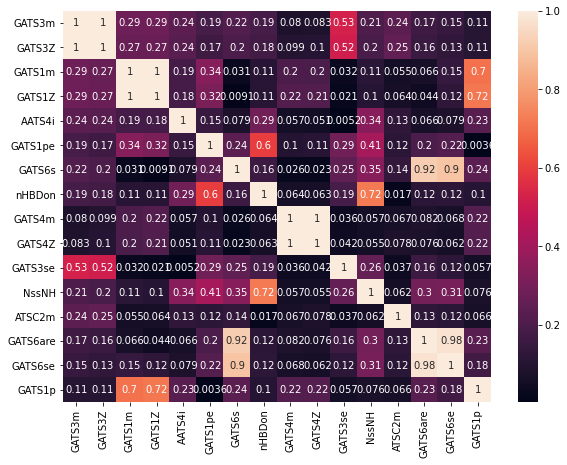

In [44]:
corr_matrix = X.corr().abs()
plt.figure(figsize=(9.6, 7.2))
sns.heatmap(corr_matrix, annot=True)
plt.savefig('figures/corr_matrix1.png', dpi=200)

In [23]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop these columns
X.drop(to_drop, axis=1, inplace=True)

# Update the list of selected features
selected = X.columns.tolist()

<a id='rfe'></a>
### RFE

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [40]:
clf = RandomForestClassifier(n_estimators=500, random_state=13)
cv = StratifiedKFold(n_splits=5)
rfe = RFECV(estimator=clf, cv=cv, min_features_to_select=4)

In [41]:
rfe.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_estimators=500, random_state=13),
      min_features_to_select=4)

In [42]:
rfe.ranking_

array([1, 1, 1, 1, 2, 5, 1, 1, 6, 1, 4, 3])

In [43]:
cols = rfe.get_support(indices=True)
selected = X.columns[cols].tolist()
print(selected)

['GATS3m', 'GATS1m', 'AATS4i', 'GATS1pe', 'GATS4m', 'GATS3se', 'ATSC2m']


<a id='selected'></a>
### Selected descriptors

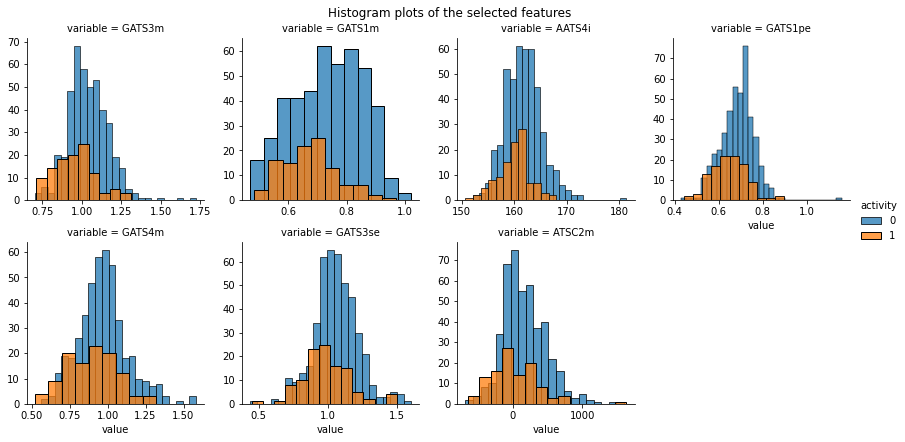

In [26]:
melt = pd.melt(training, id_vars=['CID','activity'], value_vars=selected)
g = sns.FacetGrid(data=melt, col='variable', hue='activity', sharex=False, sharey=False, col_wrap=4)
g.map(sns.histplot, 'value').add_legend()
plt.suptitle('Histogram plots of the selected features', y=1.015)
plt.savefig('figures/histogram_selected.png', dpi=128)

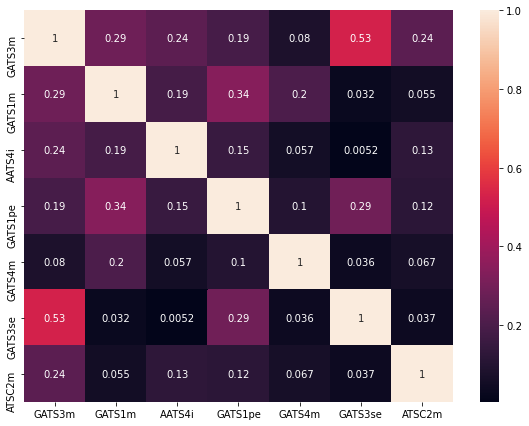

In [50]:
# Show correlation matrix of the updated selected features
corr_matrix = X[selected].corr().abs()
plt.figure(figsize=(9.6, 7.2))
sns.heatmap(corr_matrix, annot=True)
plt.savefig('figures/corr_matrix.png', dpi=200)

In [28]:
# Save the selected descriptors
with open('features.lst', 'w+') as features_file:
    features_file.write('\n'.join(selected))

<a id='constructing'></a>
## Constructing the models

In [29]:
def get_model_by_name(model_name):
    if model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=500, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='binary:logistic', random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        from sklearn.tree import DecisionTreeClassifier
        return DecisionTreeClassifier(random_state=13)
    elif model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV is used for applying probability transformation 
        # on top of the SVC outputs, so we can plot the ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))

    
def train_test_scores(X_train, X_test, y_train, y_test, pipe):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from imblearn.metrics import geometric_mean_score
    
    scores = []
    
    y_pred = pipe.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))         # test_roc_auc
    scores.append(f1_score(y_test, y_pred))              # test_f1
    scores.append(geometric_mean_score(y_test, y_pred))  # test_geometric_mean
    
    y_pred = pipe.predict(X_train)
    scores.append(roc_auc_score(y_train, y_pred))        # train_roc_auc
    scores.append(f1_score(y_train, y_pred))             # train_f1
    scores.append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
    
    return scores


def feature_transformer(X):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import OneHotEncoder

    return ColumnTransformer(transformers=[
        ('continuous', StandardScaler(), X.select_dtypes(include=float).columns.tolist()), 
        ('discrete', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=int).columns.tolist())
    ])


def kFold_pipeline(X, y, clf):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    from sklearn.model_selection import RepeatedStratifiedKFold

    transformer = feature_transformer(X)    
    pipe = make_pipeline(SMOTE(random_state=42), transformer, clf)
    
    scores_KFold = []
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=5)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 

        # Fit Pipeline
        pipe.fit(X_train, y_train)

        # Test and training scores
        scores_KFold.append(train_test_scores(X_train, X_test, y_train, y_test, pipe))
    
    scores = pd.DataFrame(scores_KFold)
    mean_scores = scores.mean().tolist()
    return mean_scores

In [30]:
# ML classfifiers
classifiers = ['LogisticRegression','RandomForestClassifier','KNeighborsClassifier',
               'LinearSVC','XGBClassifier', 'DecisionTreeClassifier']

test_metrics = ['test_f1', 'test_geometric_mean', 'test_roc_auc']
train_metrics = ['train_f1', 'train_geometric_mean', 'train_roc_auc']
columns = test_metrics + train_metrics + ['clf', 'docking']

In [31]:
merged = pd.merge(training, docking, on=['CID'])
y = merged['activity']
X = merged[selected]

In [32]:
# Training models only with the molecular descriptors

scores = []
for model_name in classifiers:
    clf = get_model_by_name(model_name)
    mean_scores = kFold_pipeline(X, y, clf)
    mean_scores.append(model_name)
    mean_scores.append('None')

    scores.append(mean_scores)

In [35]:
# Training models with molecular descriptors + docking scores

for model_name in classifiers:
    for SF in [['qvina', 'rfscore_qvina'], ['plants', 'rfscore_plants']]:
        y = merged['activity']
        X = merged[selected + SF]

        clf = get_model_by_name(model_name)
        mean_scores = kFold_pipeline(X, y, clf)
        mean_scores.append(model_name)
        mean_scores.append(SF[0])
        
        scores.append(mean_scores)
    
scores = pd.DataFrame(scores, columns=columns)
scores.to_csv('scores.csv', index=False)

<a id='docking_test'></a>
### Influence of the docking scores on the model performance

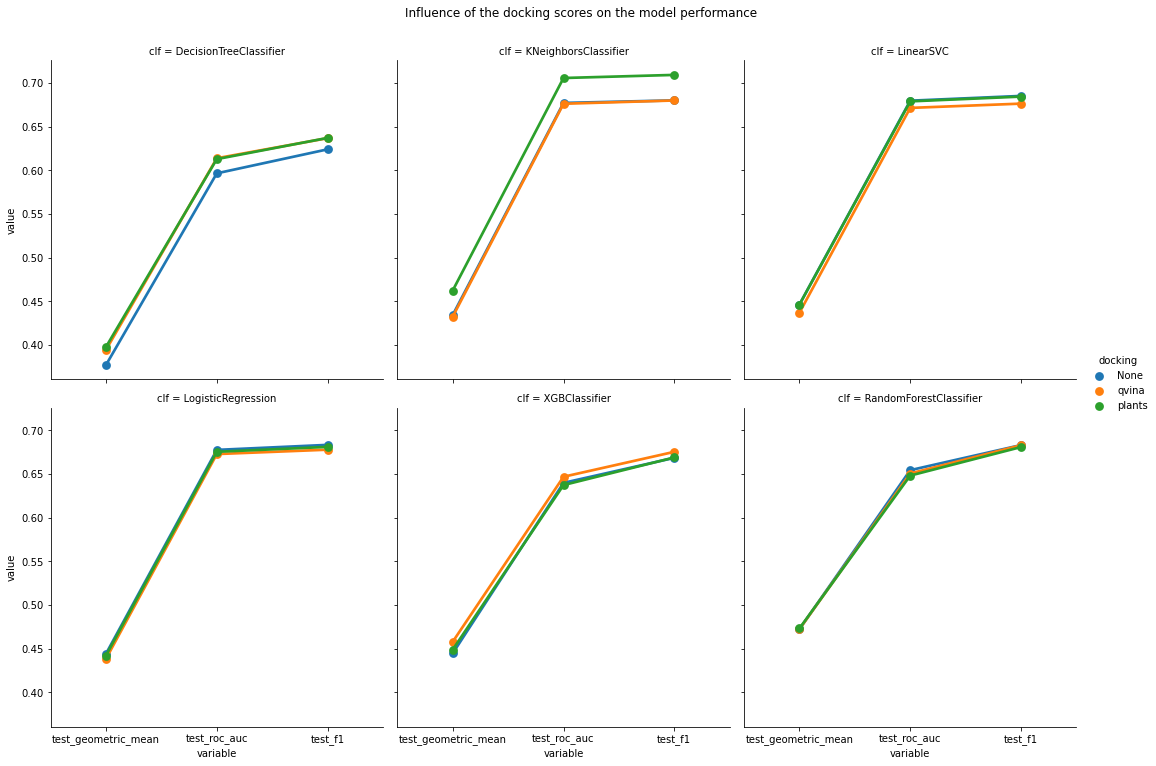

In [8]:
df = pd.melt(scores, id_vars=['clf', 'docking'], value_vars=test_metrics).sort_values(['value'])
sns.catplot(data=df, x='variable', y='value', kind='point', hue='docking', col='clf', col_wrap=3)
plt.suptitle('Influence of the docking scores on the model performance', y=1.04)
plt.savefig('figures/docking-improvement.png', dpi=200)

<a id='supplementary'></a>
## Supplementary data
<a id='docking_training'></a>
### Influence of the docking scores on the model performance (training results)

Text(0.5, 1.04, 'Influence of the docking scores on the model performance')

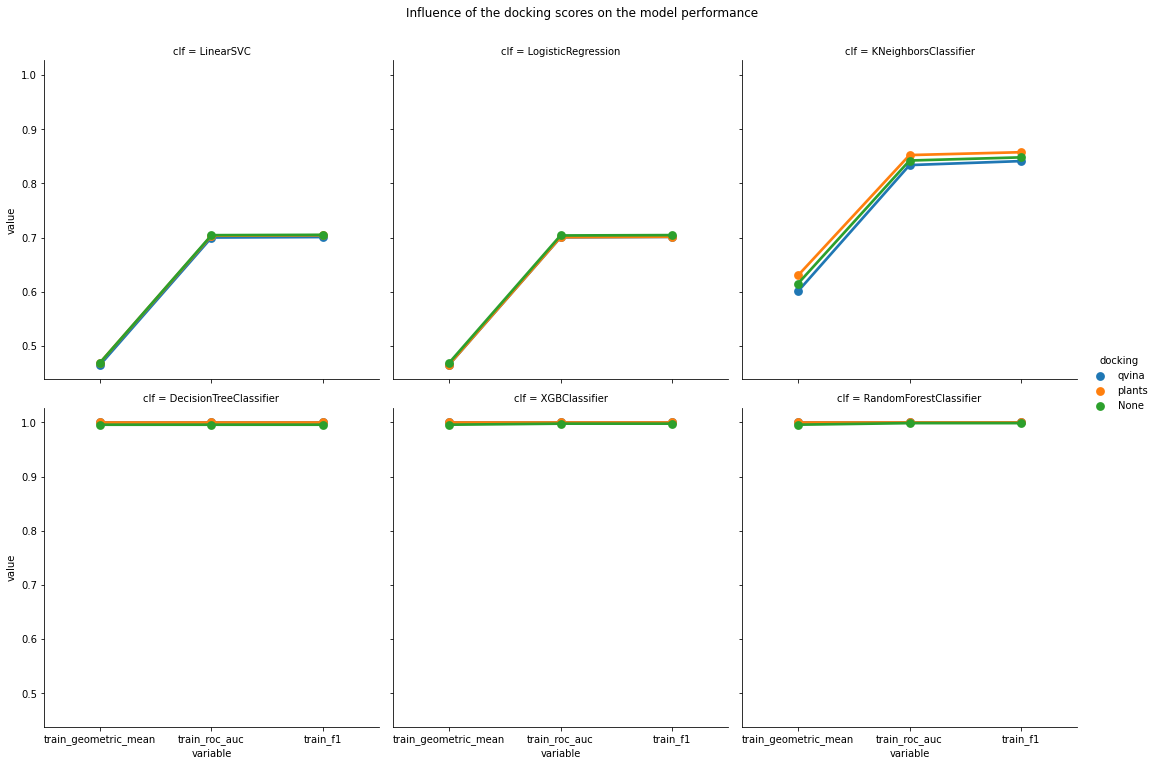

In [38]:
df = pd.melt(scores, id_vars=['clf', 'docking'], value_vars=train_metrics).sort_values(['value'])
sns.catplot(data=df, x='variable', y='value', kind='point', hue='docking', col='clf', col_wrap=3)
plt.suptitle('Influence of the docking scores on the model performance', y=1.04)